In [1]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from metric_depth.depth_anything_v2.dpt import DepthAnythingV2

%matplotlib inline

xFormers not available
xFormers not available


In [2]:
model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]}
}

Run either Outdoor or Indoor and use Metric Depth section to get the depths

# Outdoor

In [3]:
encoder = 'vitl' # or 'vits', 'vitb'
dataset = 'vkitti' # 'hypersim' for indoor model, 'vkitti' for outdoor model
max_depth = 80 # 20 for indoor model, 80 for outdoor model

model = DepthAnythingV2(**{**model_configs[encoder], 'max_depth': max_depth})
model.load_state_dict(torch.load(f'checkpoints/depth_anything_v2_metric_{dataset}_{encoder}.pth', map_location='cpu'))
model.eval()

C:\Users\adity\AppData\Local\Temp\ipykernel_10624\3899550439.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'checkpoints/depth_anythin

DepthAnythingV2(
  (pretrained): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-23): 24 x NestedTensorBlock(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (drop): Dropout(p=0.0, inplace=Fal

In [4]:
raw_img = cv2.imread('./assets/examples/demo01.jpg')
depth = model.infer_image(raw_img) # HxW depth map in meters in numpy

In [5]:
print("Number of unique depth values: ", len(np.unique(depth)))
print("Range of unique depth values: ", np.min(depth), np.max(depth))

Number of unique depth values:  2564368
Range of unique depth values:  4.945559 79.346924


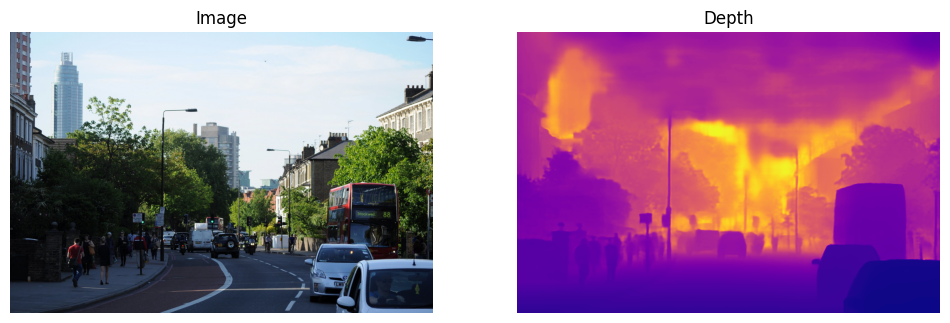

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB))
ax1.set_title('Image')
ax1.axis('off')
ax2.imshow(depth, cmap='plasma')
ax2.set_title('Depth')
ax2.axis('off')
plt.show()

# Indoor

In [3]:
encoder = 'vitl'
dataset = 'hypersim'
max_depth = 20

model = DepthAnythingV2(**{**model_configs[encoder]})
model.load_state_dict(torch.load(f'checkpoints/depth_anything_v2_metric_{dataset}_{encoder}.pth', map_location='cpu'))
model.eval()

C:\Users\adity\AppData\Local\Temp\ipykernel_11648\37523368.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'checkpoints/depth_anything_

DepthAnythingV2(
  (pretrained): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-23): 24 x NestedTensorBlock(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (drop): Dropout(p=0.0, inplace=Fal

In [4]:
raw_img = cv2.imread('./assets/examples/demo03.jpg')
depth = model.infer_image(raw_img) # HxW depth map in meters in numpy

In [5]:
print("Number of unique depth values: ", len(np.unique(depth)))
print("Range of unique depth values: ", np.min(depth), np.max(depth))

Number of unique depth values:  2128371
Range of unique depth values:  0.5527892 1.5268363


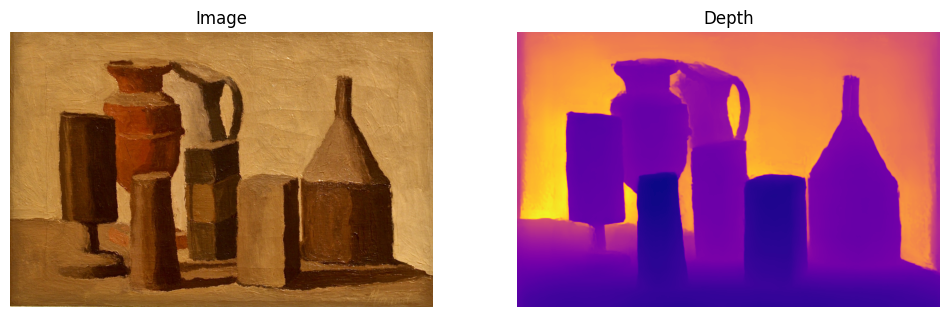

In [6]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB))
ax1.set_title('Image')
ax1.axis('off')
ax2.imshow(depth, cmap='plasma')
ax2.set_title('Depth')
ax2.axis('off')
plt.show()

# Metric Depth

In [7]:
points = []

def click_event(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        points.append((x, y))
        print(f"Clicked coordinates: ({x}, {y})")
        cv2.circle(raw_img, (x, y), 5, (0, 255, 0), -1)
        cv2.imshow("Image", raw_img)

cv2.imshow("Image", raw_img)
cv2.setMouseCallback("Image", click_event)

while True:
    key = cv2.waitKey(1) & 0xFF
    if key == 27:
        break

cv2.destroyAllWindows()

Clicked coordinates: (1831, 1191)
Clicked coordinates: (1534, 1059)
Clicked coordinates: (1071, 1041)
Clicked coordinates: (840, 812)
Clicked coordinates: (1062, 586)


Depth at (1831, 1191): 5.667686462402344 meters
Depth at (1534, 1059): 12.288352012634277 meters
Depth at (1071, 1041): 27.498071670532227 meters
Depth at (840, 812): 46.85706329345703 meters
Depth at (1062, 586): 67.5138931274414 meters


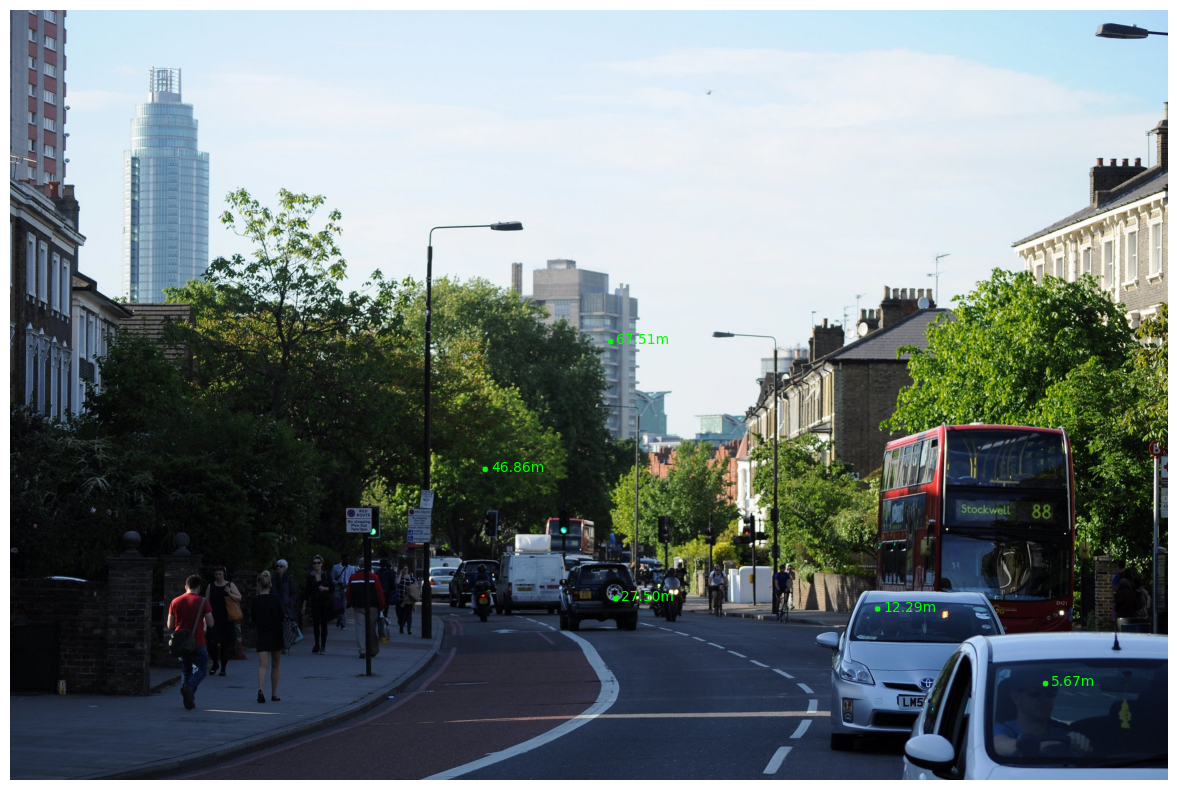

In [8]:
for point in points:
    x, y = point
    depth_value = depth[y, x]
    print(f"Depth at ({x}, {y}): {depth_value} meters")
    plt.text(x+10, y+10, f"{depth_value:.2f}m", color='lime', fontsize=10, ha='left', va='bottom')

plt.gcf().set_size_inches(15, 10)
plt.imshow(cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()